#### Bojan Tunguz, the quadruple Kaggle grandmaster who worked at NVIDIA, states that XGBoost is all you need. 
#### So, I expect that XGBoost is gonna outperform other traditional models in this dataset. However, I implemented other models for comparison purposes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime, timedelta
import requests
from collections import defaultdict
import re
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Machine learning imports
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE

In [86]:
df = pd.read_json('transactions.txt', lines=True)
df.replace('', np.nan, inplace=True)

#### If we intend to save the file in csv format

In [ ]:
df.to_csv('transactions_dataset.csv', index=False) 

In [4]:
df_csv = pd.read_csv('transactions_dataset.csv')
df.to_csv('transactions.csv', index=False)

#### If we wish we can convert the dataset to the byte

In [108]:
pd.to_pickle(df, 'transactions', protocol=4)

In [6]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


In [7]:
df.describe()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,posOnPremises,recurringAuthInd
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,0.0,786363.000000,0.0,0.0,0.0,0.0,0.0
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,136.985791,544.467338,544.183857,4757.417799,NaN,4508.739089,NaN,NaN,NaN,NaN,NaN
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,147.725569,261.524220,261.551254,2996.583810,NaN,6457.442068,NaN,NaN,NaN,NaN,NaN
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,0.000000,100.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,33.650000,310.000000,310.000000,2178.000000,NaN,689.910000,NaN,NaN,NaN,NaN,NaN
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,87.900000,535.000000,535.000000,4733.000000,NaN,2451.760000,NaN,NaN,NaN,NaN,NaN
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,191.480000,785.000000,785.000000,7338.000000,NaN,5291.095000,NaN,NaN,NaN,NaN,NaN
max,9.993896e+08,9.993896e+08,50000.000000,50000.000000,2011.540000,998.000000,998.000000,9998.000000,NaN,47498.810000,NaN,NaN,NaN,NaN,NaN


## Useful information
### Account Information
creditLimit: The maximum amount cardholders can spend
- Average limit: $10,759
- Range: $250 to $50,000

availableMoney: Remaining credit available to cardholders
- Average available: $6,251
- Some accounts have negative available credit (-$1,006)

currentBalance: Amount owed on the cards
- Average balance: $4,509
- Maximum balance: $47,499

### Transaction Details
transactionAmount: Amount of each purchase

- Average transaction: $137
- Range: $0 to $2,012
- Most transactions fall between $34-$191 (middle 50%)


However, I should mention that the same results can be achieved by seperating the categorical and numerical columns from each other

In [8]:
display(pd.DataFrame({"Features": df.columns}))

,Features
0,accountNumber
1,customerId
2,creditLimit
3,availableMoney
4,transactionDateTime
5,transactionAmount
6,merchantName
7,acqCountry
8,merchantCountryCode
9,posEntryMode


In [9]:
# Summary statistics for numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns
print("\nSummary statistics for numeric columns:")
try:
    display(df[numeric_cols].describe())
except NameError:
    print(df[numeric_cols].describe())


Summary statistics for numeric columns:


,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,posOnPremises,recurringAuthInd
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,0.0,786363.000000,0.0,0.0,0.0,0.0,0.0
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,136.985791,544.467338,544.183857,4757.417799,NaN,4508.739089,NaN,NaN,NaN,NaN,NaN
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,147.725569,261.524220,261.551254,2996.583810,NaN,6457.442068,NaN,NaN,NaN,NaN,NaN
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,0.000000,100.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,33.650000,310.000000,310.000000,2178.000000,NaN,689.910000,NaN,NaN,NaN,NaN,NaN
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,87.900000,535.000000,535.000000,4733.000000,NaN,2451.760000,NaN,NaN,NaN,NaN,NaN
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,191.480000,785.000000,785.000000,7338.000000,NaN,5291.095000,NaN,NaN,NaN,NaN,NaN
max,9.993896e+08,9.993896e+08,50000.000000,50000.000000,2011.540000,998.000000,998.000000,9998.000000,NaN,47498.810000,NaN,NaN,NaN,NaN,NaN


In [10]:
bool_cols = df.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    print("\nBoolean columns summary:")
    for col in bool_cols:
        true_pct = (df[col].sum() / len(df) * 100).round(2)
        print(f"- {col}: {true_pct}% True, {100-true_pct}% False")


Boolean columns summary:
- cardPresent: 44.87% True, 55.13% False
- expirationDateKeyInMatch: 0.13% True, 99.87% False
- isFraud: 1.58% True, 98.42% False


In [11]:
# Most common values in categorical columns
cat_cols = df.select_dtypes(include=['object']).columns
print("\nCategorical columns overview:")
for col in cat_cols:
    if df[col].nunique() < 20:  # Only show full distribution for columns with few values
        print(f"\n{col} distribution:")
        value_counts = df[col].value_counts(dropna=False)
        value_df = pd.DataFrame({
            'Value': value_counts.index,
            'Count': value_counts.values,
            'Percentage': (value_counts.values / len(df) * 100).round(2)
        })
        try:
            display(value_df)
        except NameError:
            print(value_df)
    else:
        print(f"\nTop 10 values for {col} (out of {df[col].nunique()} unique values):")
        value_counts = df[col].value_counts(dropna=False).head(10)
        value_df = pd.DataFrame({
            'Value': value_counts.index,
            'Count': value_counts.values,
            'Percentage': (value_counts.values / len(df) * 100).round(2)
        })
        try:
            display(value_df)
        except NameError:
            print(value_df)


Categorical columns overview:

Top 10 values for transactionDateTime (out of 776637 unique values):


,Value,Count,Percentage
0,2016-12-25T14:04:15,4,0.0
1,2016-05-28T14:24:41,4,0.0
2,2016-06-02T11:27:00,3,0.0
3,2016-04-24T22:44:16,3,0.0
4,2016-04-14T13:11:10,3,0.0
5,2016-12-23T12:09:17,3,0.0
6,2016-04-30T20:27:34,3,0.0
7,2016-02-25T17:00:11,3,0.0
8,2016-04-23T12:11:33,3,0.0
9,2016-08-13T13:09:46,3,0.0



Top 10 values for merchantName (out of 2490 unique values):


,Value,Count,Percentage
0,Uber,25613,3.26
1,Lyft,25523,3.25
2,oldnavy.com,16992,2.16
3,staples.com,16980,2.16
4,alibaba.com,16959,2.16
5,apple.com,16898,2.15
6,walmart.com,16873,2.15
7,cheapfast.com,16858,2.14
8,ebay.com,16842,2.14
9,target.com,16813,2.14



acqCountry distribution:


,Value,Count,Percentage
0,US,774709,98.52
1,NaN,4562,0.58
2,MEX,3130,0.40
3,CAN,2424,0.31
4,PR,1538,0.20



merchantCountryCode distribution:


,Value,Count,Percentage
0,US,778511,99.00
1,MEX,3143,0.40
2,CAN,2426,0.31
3,PR,1559,0.20
4,NaN,724,0.09



posEntryMode distribution:


,Value,Count,Percentage
0,05,315035,40.06
1,09,236481,30.07
2,02,195934,24.92
3,90,19576,2.49
4,80,15283,1.94
5,NaN,4054,0.52



posConditionCode distribution:


,Value,Count,Percentage
0,01,628787,79.96
1,08,149634,19.03
2,99,7533,0.96
3,NaN,409,0.05



merchantCategoryCode distribution:


,Value,Count,Percentage
0,online_retail,202156,25.71
1,fastfood,112138,14.26
2,entertainment,80098,10.19
3,food,75490,9.60
4,online_gifts,66238,8.42
5,rideshare,51136,6.50
6,hotels,34097,4.34
7,fuel,23910,3.04
8,subscriptions,22901,2.91
9,auto,21651,2.75



Top 10 values for currentExpDate (out of 165 unique values):


,Value,Count,Percentage
0,03/2029,5103,0.65
1,08/2024,5087,0.65
2,10/2023,5075,0.65
3,05/2027,5063,0.64
4,01/2021,5041,0.64
5,10/2032,5039,0.64
6,08/2030,5029,0.64
7,08/2022,5026,0.64
8,07/2031,5022,0.64
9,05/2026,5021,0.64



Top 10 values for accountOpenDate (out of 1820 unique values):


,Value,Count,Percentage
0,2014-06-21,33623,4.28
1,2014-09-30,13335,1.70
2,2014-05-22,11353,1.44
3,2012-10-09,10867,1.38
4,2014-10-02,10653,1.35
5,2014-11-05,6693,0.85
6,2014-12-04,6584,0.84
7,2015-03-01,5962,0.76
8,2015-02-21,5881,0.75
9,2015-08-14,5503,0.70



Top 10 values for dateOfLastAddressChange (out of 2184 unique values):


,Value,Count,Percentage
0,2016-03-15,3819,0.49
1,2016-01-06,3740,0.48
2,2016-01-04,3558,0.45
3,2016-06-08,3355,0.43
4,2016-04-04,3194,0.41
5,2016-02-22,3102,0.39
6,2016-03-23,3091,0.39
7,2016-04-07,3036,0.39
8,2016-05-19,2969,0.38
9,2016-01-01,2925,0.37



transactionType distribution:


,Value,Count,Percentage
0,PURCHASE,745193,94.76
1,REVERSAL,20303,2.58
2,ADDRESS_VERIFICATION,20169,2.56
3,NaN,698,0.09


In [62]:
print(f"Dimensions: {df.shape}")

Dimensions: (786363, 29)


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                781801 non-null  object 
 8   merchantCountryCode       785639 non-null  object 
 9   posEntryMode              782309 non-null  object 
 10  posConditionCode          785954 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

###  IN other words

In [14]:
df.isnull().sum()

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

I realized that among 29 features we have at least 6 features that have not any values and all contain null value

In [15]:
(df.isnull().sum() / len(df) * 100).round(2)

accountNumber                 0.00
customerId                    0.00
creditLimit                   0.00
availableMoney                0.00
transactionDateTime           0.00
transactionAmount             0.00
merchantName                  0.00
acqCountry                    0.58
merchantCountryCode           0.09
posEntryMode                  0.52
posConditionCode              0.05
merchantCategoryCode          0.00
currentExpDate                0.00
accountOpenDate               0.00
dateOfLastAddressChange       0.00
cardCVV                       0.00
enteredCVV                    0.00
cardLast4Digits               0.00
transactionType               0.09
echoBuffer                  100.00
currentBalance                0.00
merchantCity                100.00
merchantState               100.00
merchantZip                 100.00
cardPresent                   0.00
posOnPremises               100.00
recurringAuthInd            100.00
expirationDateKeyInMatch      0.00
isFraud             

In [16]:
df.nunique()

accountNumber                 5000
customerId                    5000
creditLimit                     10
availableMoney              521915
transactionDateTime         776637
transactionAmount            66038
merchantName                  2490
acqCountry                       4
merchantCountryCode              4
posEntryMode                     5
posConditionCode                 3
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1820
dateOfLastAddressChange       2184
cardCVV                        899
enteredCVV                     976
cardLast4Digits               5245
transactionType                  3
echoBuffer                       0
currentBalance              487318
merchantCity                     0
merchantState                    0
merchantZip                      0
cardPresent                      2
posOnPremises                    0
recurringAuthInd                 0
expirationDateKeyInMatch         2
isFraud             

In [17]:
df.creditLimit.unique()

array([ 5000,  2500, 50000, 15000, 10000,   250,   500,  1000,  7500,
       20000])

Reference for the color selection: https://seaborn.pydata.org/tutorial/color_palettes.html

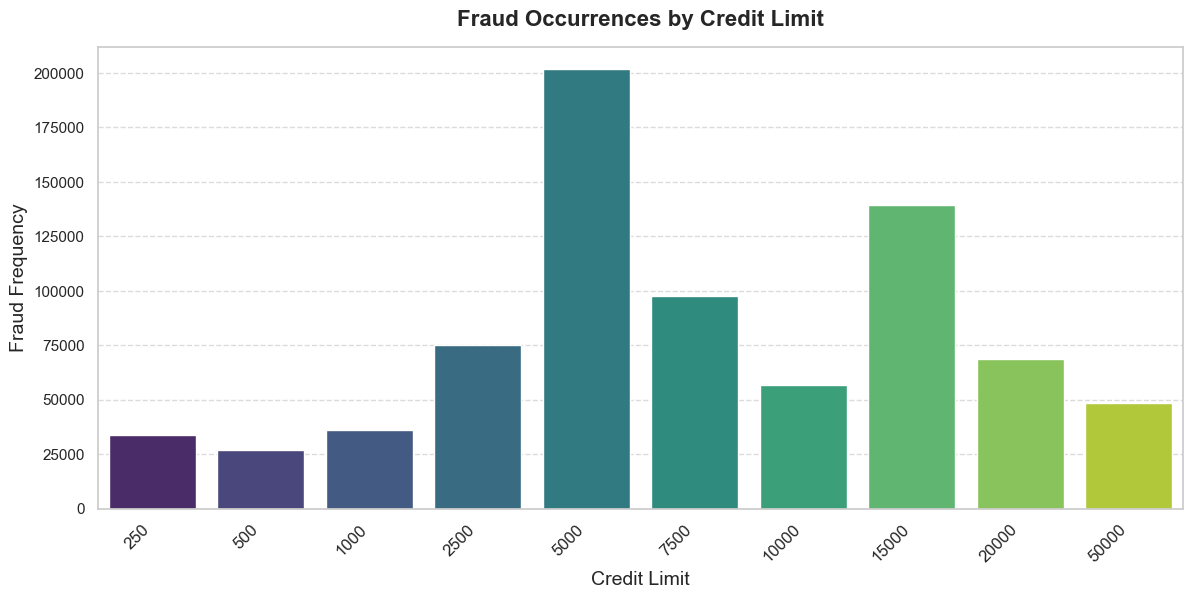

In [18]:
# Compute fraud occurrence per credit limit
credit_limit_counts = df.groupby('creditLimit')['isFraud'].count().reset_index()
credit_limit_counts.columns = ['CreditLimit', 'Frequency']

# Set figure size and theme
plt.figure(figsize=(14, 6))
sns.set_theme(style="whitegrid")

# Create the bar plot
ax = sns.barplot(x="CreditLimit", y="Frequency", data=credit_limit_counts, palette="viridis")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add titles and labels
plt.title("Fraud Occurrences by Credit Limit", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Credit Limit", fontsize=14)
plt.ylabel("Fraud Frequency", fontsize=14)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [25]:
numeric_cols = df.select_dtypes(include=['number']).columns
display(pd.DataFrame(numeric_cols))

,0
0,accountNumber
1,customerId
2,creditLimit
3,availableMoney
4,transactionAmount
5,cardCVV
6,enteredCVV
7,cardLast4Digits
8,echoBuffer
9,currentBalance


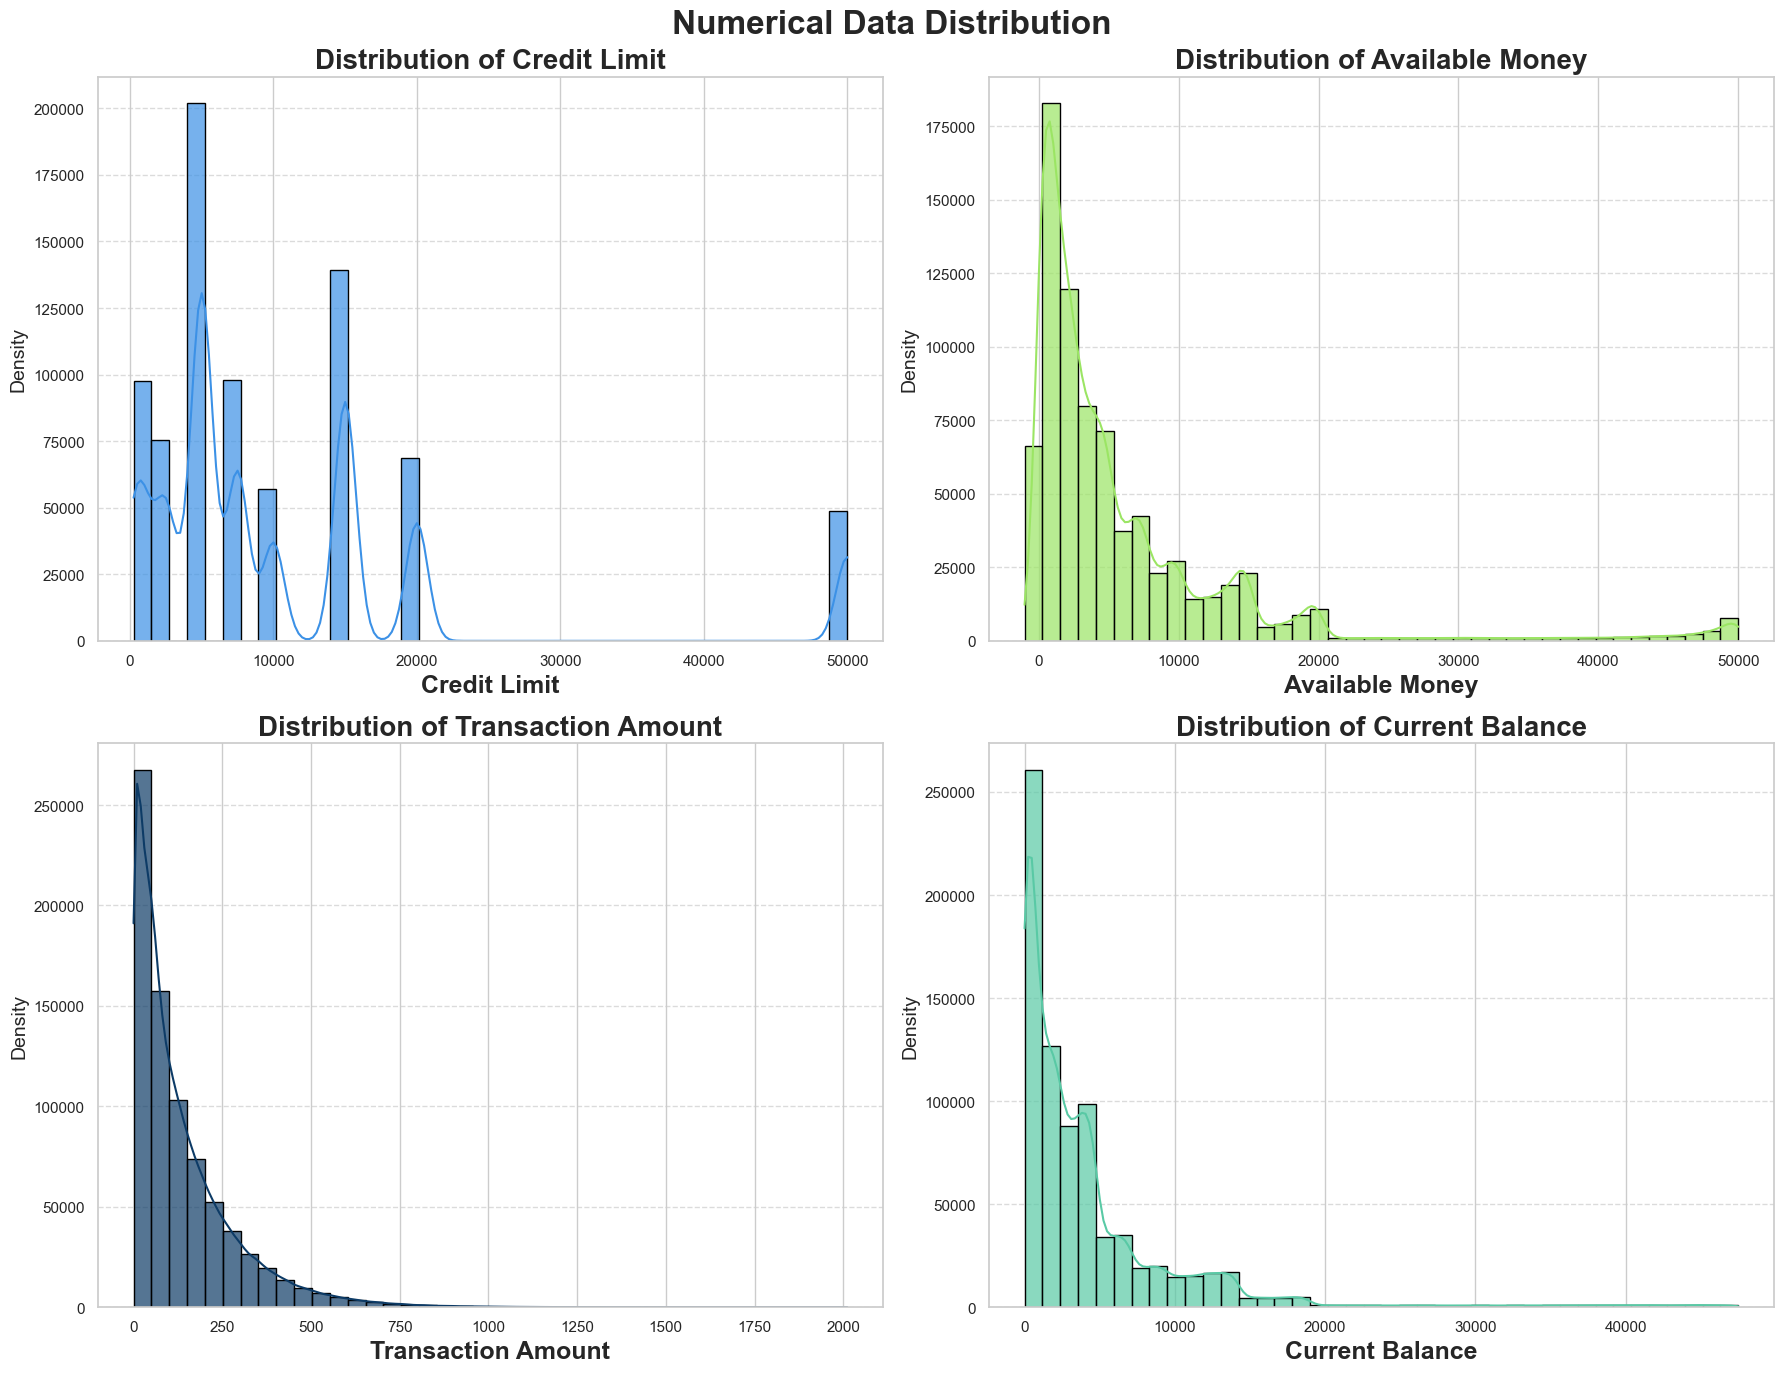

In [26]:
# Set figure size
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Define numeric columns and their neat labels
numeric_cols = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']
neat_cols = ['Credit Limit', 'Available Money', 'Transaction Amount', 'Current Balance']
colors = ['#3C91E6', '#9BE564', '#0D3B66', '#59C9A5']

counter = 0

# Loop through the subplots
for i in range(2):
    for j in range(2):
        col = numeric_cols[counter]
        
        # Plot histogram with KDE overlay
        sns.histplot(df[col], ax=ax[i][j], bins=40, kde=True, color=colors[counter], edgecolor='black', alpha=0.7)
        
        # Improve readability
        ax[i][j].set_xlabel(neat_cols[counter], fontsize=18, fontweight='bold')
        ax[i][j].set_ylabel('Density', fontsize=14)
        ax[i][j].set_title(f'Distribution of {neat_cols[counter]}', fontsize=20, fontweight='bold')
        ax[i][j].grid(axis='y', linestyle='--', alpha=0.7)
        
        counter += 1

# Add a bold title
fig.suptitle('Numerical Data Distribution', fontsize=24, fontweight='bold', y=0.98)

# Improve layout
fig.tight_layout()

# Show the plot
plt.show()

In [19]:
print("\nTransaction Amount Statistics by Merchant Category:")
category_stats = df.groupby('merchantCategoryCode')['transactionAmount'].agg(
    ['count', 'mean', 'median', 'min', 'max']).sort_values('count', ascending=False)
display(category_stats)


Transaction Amount Statistics by Merchant Category:


,count,mean,median,min,max
merchantCategoryCode,,,,,
online_retail,202156,145.231632,98.950,0.0,2011.54
fastfood,112138,145.591507,99.485,0.0,1905.30
entertainment,80098,146.041694,100.120,0.0,1562.32
food,75490,145.313906,98.680,0.0,1873.97
online_gifts,66238,146.126042,99.970,0.0,1566.37
rideshare,51136,146.220783,100.080,0.0,1398.23
hotels,34097,145.585076,99.730,0.0,1546.48
fuel,23910,45.180771,45.870,0.0,82.57
subscriptions,22901,146.900673,100.800,0.0,1440.01


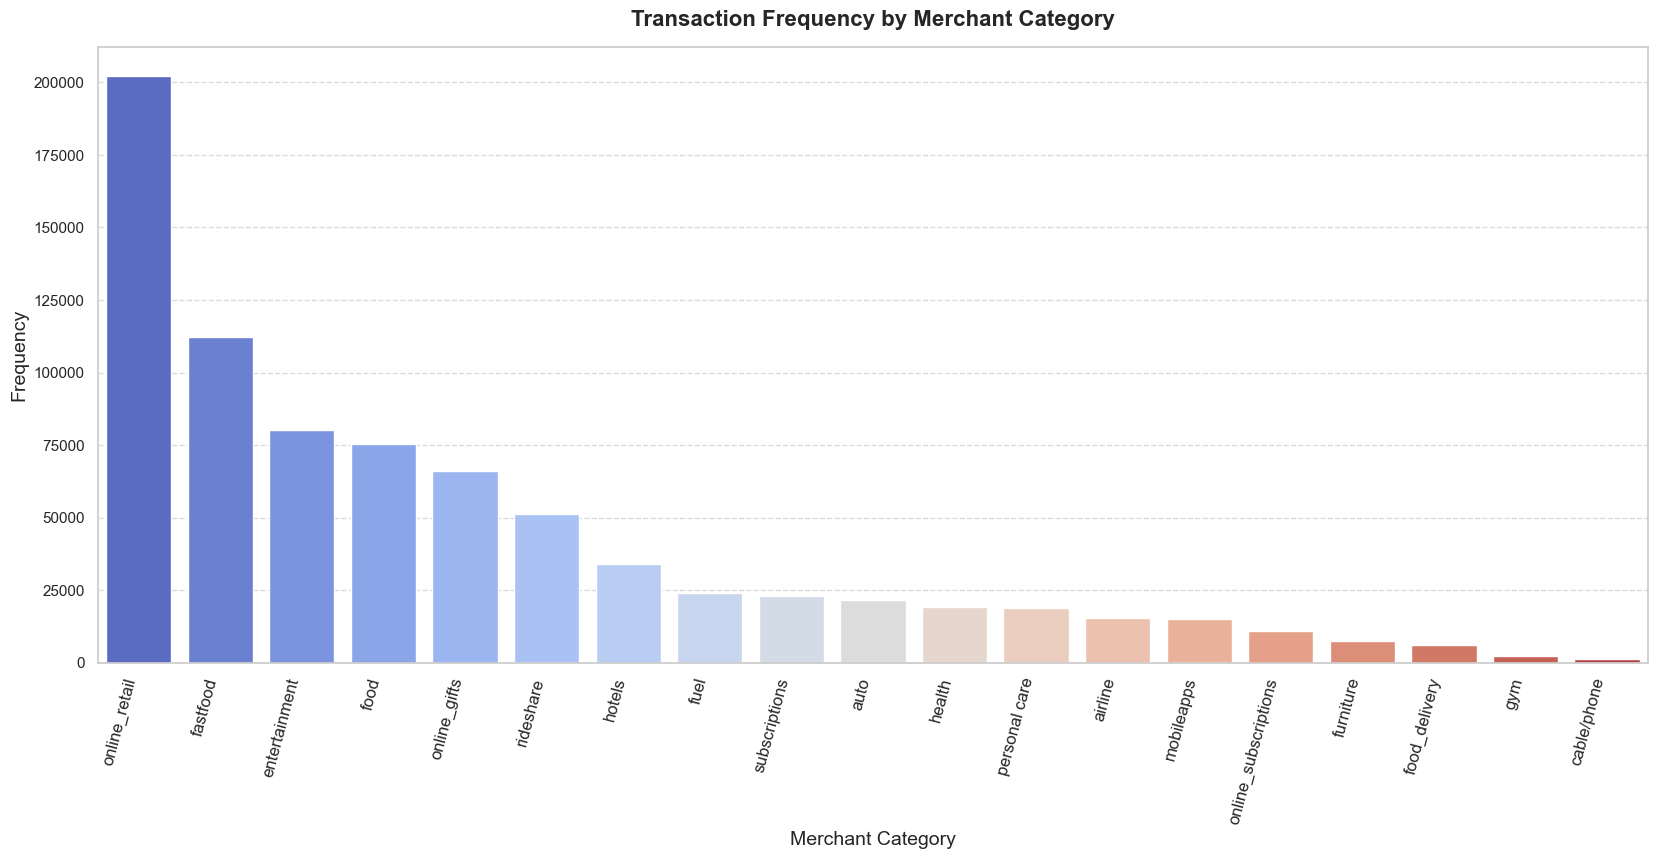

In [21]:
# Get category frequency and sort in descending order
merchant_category_counts = df['merchantCategoryCode'].value_counts().reset_index()
merchant_category_counts.columns = ['MerchantCategory', 'Freq']

# Set figure size
plt.figure(figsize=(20, 8))

# Use seaborn barplot with a color palette
sns.barplot(x='MerchantCategory', y='Freq', data=merchant_category_counts, palette='coolwarm')

# Rotate x-axis labels for better readability
plt.xticks(rotation=75, ha='right', fontsize=12)

# Add titles and labels
plt.title("Transaction Frequency by Merchant Category", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Merchant Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [27]:
df.acqCountry.unique()

array(['US', nan, 'CAN', 'MEX', 'PR'], dtype=object)

In [28]:
df.merchantCountryCode.unique()

array(['US', 'CAN', nan, 'PR', 'MEX'], dtype=object)

In [29]:
df.acqCountry.value_counts()

acqCountry
US     774709
MEX      3130
CAN      2424
PR       1538
Name: count, dtype: int64

In [30]:
print(df['transactionType'].unique())

['PURCHASE' 'ADDRESS_VERIFICATION' 'REVERSAL' nan]


In [31]:
df['isFraud'].value_counts()

isFraud
False    773946
True      12417
Name: count, dtype: int64

skewed dataset

In [32]:
print(round(df['isFraud'].value_counts() [1] / len(df),4))

0.0158


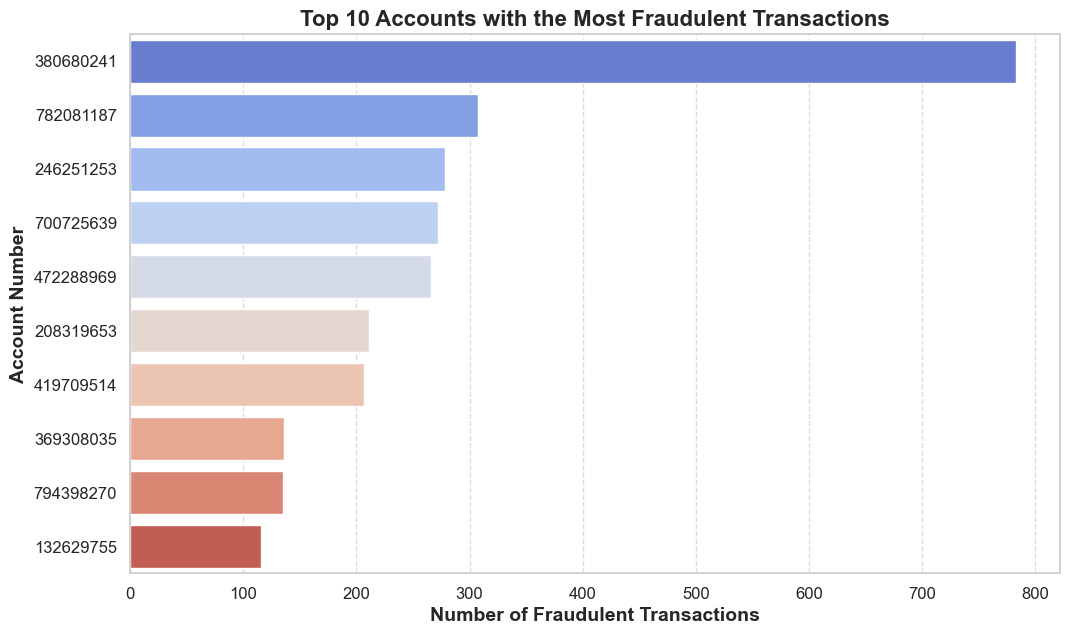

In [36]:
# Filter fraud transactions
fraud_transactions_only = df[df['isFraud'] == True]

# Get top 10 fraudulent accounts
top10_fraudulent_accounts = fraud_transactions_only['accountNumber'].value_counts().head(10)

# Set figure size
plt.figure(figsize=(12, 7))

# Create a horizontal bar plot
sns.barplot(
    y=top10_fraudulent_accounts.index.astype(str),  # Ensure account numbers display properly
    x=top10_fraudulent_accounts.values,
    palette="coolwarm"  # Alternative color scheme for better contrast
)

# Customize labels and title
plt.xlabel('Number of Fraudulent Transactions', fontsize=14, fontweight='bold')
plt.ylabel('Account Number', fontsize=14, fontweight='bold')
plt.title('Top 10 Accounts with the Most Fraudulent Transactions', fontsize=16, fontweight='bold')

# Enhance grid and aesthetics
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

All of these accounts are suspicious as each has more than one hundred fraud transactions

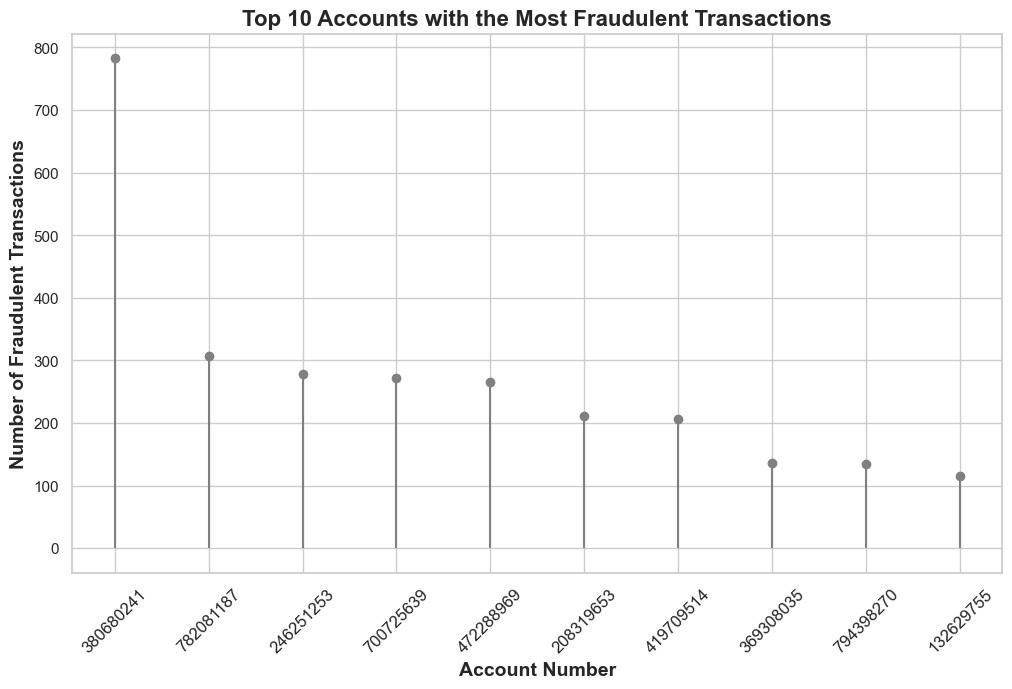

In [37]:
plt.figure(figsize=(12, 7))

# Create a lollipop plot
plt.stem(top10_fraudulent_accounts.index.astype(str), top10_fraudulent_accounts.values, linefmt="gray", markerfmt="o", basefmt=" ")

# Customize labels and title
plt.xlabel('Account Number', fontsize=14, fontweight='bold')
plt.ylabel('Number of Fraudulent Transactions', fontsize=14, fontweight='bold')
plt.title('Top 10 Accounts with the Most Fraudulent Transactions', fontsize=16, fontweight='bold')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, fontsize=12)

# Show the plot
plt.show()

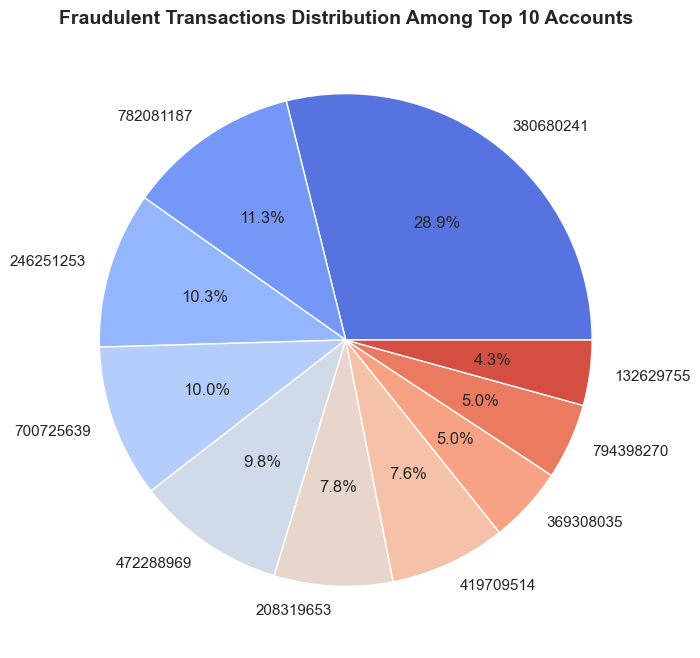

In [38]:
plt.figure(figsize=(8, 8))
plt.pie(top10_fraudulent_accounts, labels=top10_fraudulent_accounts.index.astype(str), autopct='%1.1f%%', colors=sns.color_palette("coolwarm", len(top10_fraudulent_accounts)))
plt.title('Fraudulent Transactions Distribution Among Top 10 Accounts', fontsize=14, fontweight='bold')
plt.show()

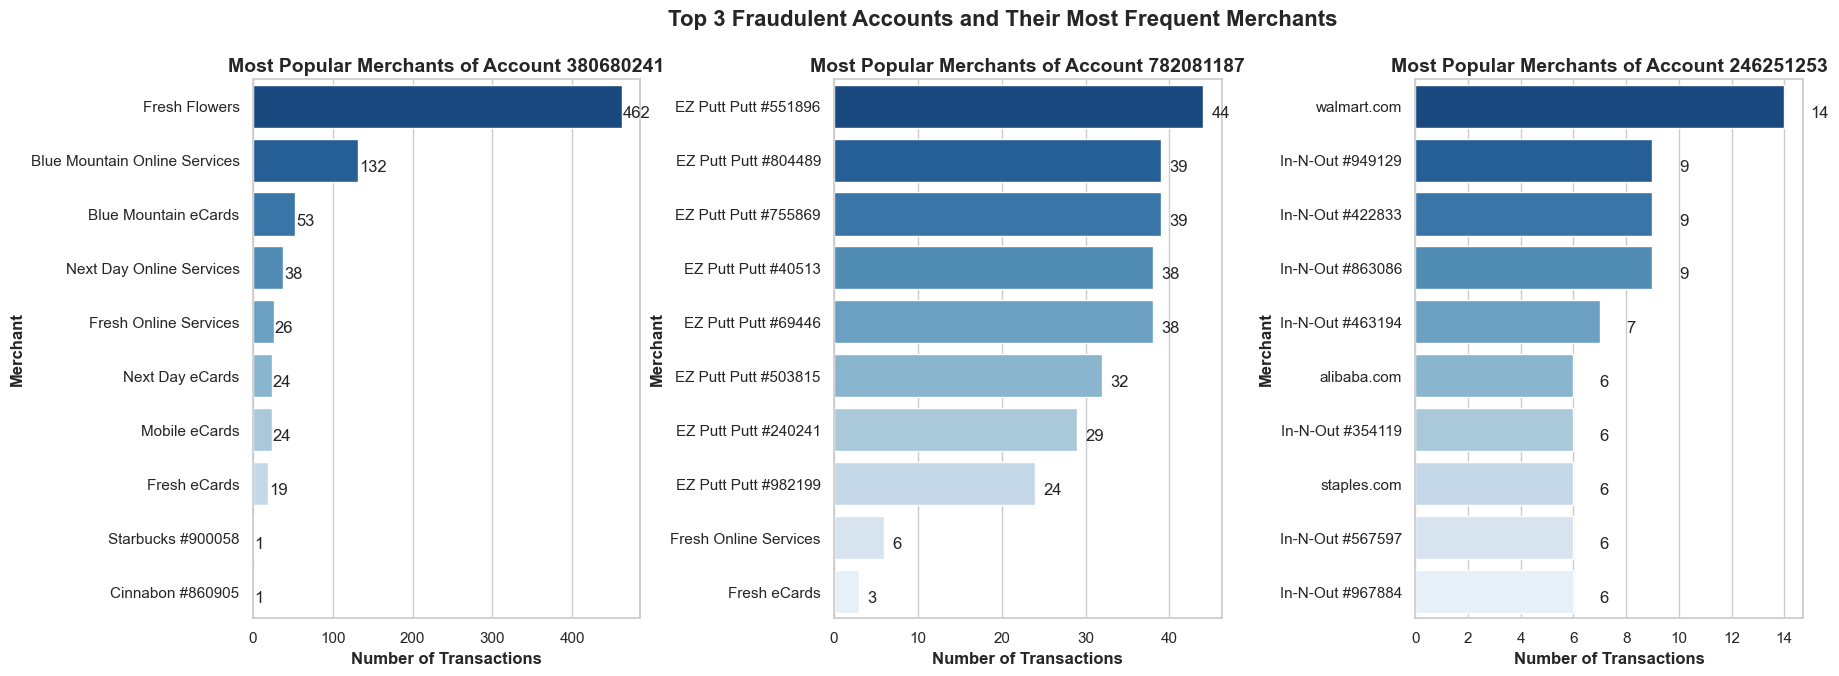

In [40]:
# Get the top 3 fraudulent accounts
top3_fraud_accounts = top10_fraudulent_accounts.index[:3]

# Set figure size for subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
plt.subplots_adjust(wspace=0.5)

# Loop through the top 3 fraudulent accounts
for i, fraud_account in enumerate(top3_fraud_accounts):
    
    # Filter data for the current fraud account
    fraud_data = df[(df['accountNumber'] == fraud_account) & (df['isFraud'] == True)]
    
    # Count transactions per merchant
    fraud_top_merchants = fraud_data['merchantName'].value_counts().head(10)  # Get top 10 merchants

    # Create horizontal bar plot
    ax = sns.barplot(
        y=fraud_top_merchants.index,
        x=fraud_top_merchants.values,
        ax=axes[i],
        palette="Blues_r"
    )
    
    # Annotate bars with transaction counts
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 1,  # Adjusted for better alignment
                p.get_y() + p.get_height()/2. + 0.2,
                int(width),
                ha="left", fontsize=12)

    # Set labels and titles
    axes[i].set_xlabel('Number of Transactions', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Merchant', fontsize=12, fontweight='bold')
    axes[i].set_title(f'Most Popular Merchants of Account {fraud_account}', fontsize=14, fontweight='bold')

# Add a main title
fig.suptitle('Top 3 Fraudulent Accounts and Their Most Frequent Merchants', fontsize=16, fontweight='bold')

# Show the plots
plt.show()

In [46]:
# Filter fraud transactions and exclude transactions with amount 0
fraud_transactions_only = df[(df['isFraud'] == True) & (df['transactionAmount'] > 0)]

# Get the most common fraudulent transaction amounts (excluding 0)
top10_fraud_amounts = fraud_transactions_only['transactionAmount'].value_counts().head(10)
print(top10_fraud_amounts)

transactionAmount
156.01    6
34.63     6
46.37     5
210.11    5
72.83     4
95.43     4
53.37     4
163.42    4
312.77    4
99.55     4
Name: count, dtype: int64


In [33]:
df['merchantCategoryCode'].unique()

array(['rideshare', 'entertainment', 'mobileapps', 'fastfood',
       'food_delivery', 'auto', 'online_retail', 'gym', 'health',
       'personal care', 'food', 'fuel', 'online_subscriptions',
       'online_gifts', 'hotels', 'airline', 'furniture', 'subscriptions',
       'cable/phone'], dtype=object)

In [34]:
display(pd.DataFrame(df.transactionType.value_counts()).reset_index(drop=False))

,transactionType,count
0,PURCHASE,745193
1,REVERSAL,20303
2,ADDRESS_VERIFICATION,20169


In [50]:
display(pd.DataFrame(df.transactionAmount.describe().round(2)))

,transactionAmount
count,786363.00
mean,136.99
std,147.73
min,0.00
25%,33.65
50%,87.90
75%,191.48
max,2011.54


In [88]:
# Create a copy of df before dropping columns
df_copy = df.copy()

# Drop unnecessary columns from df_copy
df_copy.drop(['merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd', 'echoBuffer'], axis=1, inplace=True)

# Check for missing values in the modified df
print(df_copy.isnull().sum())

accountNumber                  0
customerId                     0
creditLimit                    0
availableMoney                 0
transactionDateTime            0
transactionAmount              0
merchantName                   0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
currentExpDate                 0
accountOpenDate                0
dateOfLastAddressChange        0
cardCVV                        0
enteredCVV                     0
cardLast4Digits                0
transactionType              698
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
dtype: int64


Dropping columns from df_copy which are not necessary foe predictive models, dimensionality reduction

In [89]:
df_copy['matchingCVV'] = df_copy['cardCVV'] == df_copy['enteredCVV']

for col in ['cardPresent', 'matchingCVV', 'expirationDateKeyInMatch', 'isFraud']:
    df_copy[col] = df_copy[col].replace({False: 0, True: 1})
account_number = df_copy['accountNumber']
df_copy.drop([
         'cardLast4Digits',
         'merchantName',
         'accountOpenDate',
         'transactionDateTime',
         'currentExpDate',
         'customerId',
         'dateOfLastAddressChange',
         'accountNumber',
         'enteredCVV',
         'cardCVV',
         ], inplace=True, axis=1)

In [90]:
df_copy.isnull().sum()

creditLimit                    0
availableMoney                 0
transactionAmount              0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
transactionType              698
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
matchingCVV                    0
dtype: int64

In [80]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder

In [101]:
df_under = df_copy.copy()
df_over = df_copy.copy()

In [96]:
df_under.shape

(786363, 13)

In [102]:
ros = RandomUnderSampler()
y = df_under['isFraud']
df_under.drop('isFraud', inplace=True, axis=1)
new_x_under, new_y_under = ros.fit_resample(df_under, y)
print(f'Before Random Under Sampling: {df_under.shape}')
print(f'After Random Under Sampling: {new_x_under.shape}')

Before Random Under Sampling: (786363, 13)
After Random Under Sampling: (24834, 13)


In [103]:
ros = RandomOverSampler(random_state=42)

y = df_over['isFraud']
df_over.drop('isFraud', inplace=True, axis=1)

# Apply Random Oversampling
new_x_over, new_y_over = ros.fit_resample(df_over, y)

print(f'Before Random Oversampling: {df_over.shape}')
print(f'After Random Oversampling: {new_x_over.shape}')

Before Random Oversampling: (786363, 13)
After Random Oversampling: (1547892, 13)


- SMOTE does not support missing values
- Generates new fraud samples

In [81]:
df_smote = df_copy.copy()


# Separate target variable
y = df_smote['isFraud'].copy()
df_smote.drop('isFraud', axis=1, inplace=True)

# Identify categorical columns
categorical_cols = df_smote.select_dtypes(include=['object', 'category']).columns

# Apply Label Encoding (suitable if categories are limited)
le = LabelEncoder()
for col in categorical_cols:
    df_smote[col] = le.fit_transform(df_smote[col].astype(str))

# Fill NaN values appropriately
numeric_cols = df_smote.select_dtypes(include=[np.number]).columns
df_smote[numeric_cols] = df_smote[numeric_cols].fillna(df_smote[numeric_cols].median())  # Numeric: Median

# Verify no NaN values remain before SMOTE
print("Missing values before SMOTE:", df_smote.isnull().sum().sum())

# Apply SMOTE
smote = SMOTE(random_state=42)
new_x, new_y = smote.fit_resample(df_smote, y)

print(f'Before SMOTE: {df_smote.shape}')
print(f'After SMOTE: {new_x.shape}')

Missing values before SMOTE: 0
Before SMOTE: (786363, 13)
After SMOTE: (1547892, 13)


We can apply other SMOTE alternatives such as SMOTE-Tomek and SMOTE-ENN. Eas has their own tradeoffs.

In [104]:
df_smote_pipline = df_copy.copy()

In [ ]:
pipeline = ColumnTransformer([
    ('cat_pipe', Pipeline([
        ('cat_imputer', SimpleImputer(strategy='most_frequent')),
        ('one_hot', OneHotEncoder(handle_unknown='ignore'))
    ]),
     ['merchantCountryCode',
      'merchantCategoryCode',
      'posConditionCode',
      'posEntryMode',
      'transactionType',
      'acqCountry']),
], remainder='passthrough')

In [51]:
# Convert object columns to categories where appropriate
for col in ['merchantCategoryCode', 'transactionType']:
    df[col] = df[col].astype('category')

In [52]:
df_clean = df.copy()

# Convert date/time columns to datetime
date_cols = ['transactionDateTime', 'accountOpenDate', 'dateOfLastAddressChange']
for col in date_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

In [53]:
# Fill missing values
# For numeric columns, fill with median
numeric_cols = df_clean.select_dtypes(include=['number']).columns
for col in numeric_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

In [54]:
# For categorical columns, fill with most common value
cat_cols = df_clean.select_dtypes(include=['object']).columns
for col in cat_cols:
    most_common = df_clean[col].mode()[0]
    df_clean[col] = df_clean[col].fillna(most_common)

In [65]:
df_clean.head

<bound method NDFrame.head of         accountNumber  customerId  creditLimit  availableMoney  \
0           737265056   737265056         5000         5000.00   
1           737265056   737265056         5000         5000.00   
2           737265056   737265056         5000         5000.00   
3           737265056   737265056         5000         5000.00   
4           830329091   830329091         5000         5000.00   
...               ...         ...          ...             ...   
786358      732852505   732852505        50000        48904.96   
786359      732852505   732852505        50000        48785.04   
786360      732852505   732852505        50000        48766.15   
786361      732852505   732852505        50000        48716.72   
786362      732852505   732852505        50000        48666.83   

       transactionDateTime  transactionAmount         merchantName acqCountry  \
0      2016-08-13 14:27:32              98.55                 Uber         US   
1      2016-10-

In [55]:
df_dup = df.copy()

In [56]:
# Ensure datetime format for transaction dates
df_dup['transactionDateTime'] = pd.to_datetime(df_dup['transactionDateTime'])

In [57]:
# Sort by account number and transaction date
df_dup = df_dup.sort_values(['accountNumber', 'transactionDateTime'])

In [58]:
# 1. Identify explicit reversals
explicit_reversals = df_dup[df_dup['transactionType'] == 'REVERSAL'].copy()
print(f"\nExplicit reversal transactions found: {len(explicit_reversals)}")


Explicit reversal transactions found: 20303


This part is computationally heavy so at the end, I will cache the results in order to save time and memory usage if we want to reproduce the code later.

In [105]:
# Create a map to match reversals with original transactions
matched_reversals = []
total_reversal_amount = 0

for _, reversal in explicit_reversals.iterrows():
    # Look for matching original transaction
    potential_originals = df_dup[
        (df_dup['accountNumber'] == reversal['accountNumber']) &
        (df_dup['merchantName'] == reversal['merchantName']) &
        (abs(df_dup['transactionAmount'] - reversal['transactionAmount']) < 0.01) &
        (df_dup['transactionDateTime'] < reversal['transactionDateTime']) &
        (df_dup['transactionType'] != 'REVERSAL')
    ]
    
    if len(potential_originals) > 0:
        # Find the closest transaction by time
        potential_originals = potential_originals.assign(timeDiff = (reversal['transactionDateTime'] - potential_originals['transactionDateTime']))
        closest_original = potential_originals.loc[potential_originals['timeDiff'].idxmin()]
        
        matched_reversals.append({
            'reversal_id': reversal.name,
            'original_id': closest_original.name,
            'accountNumber': reversal['accountNumber'],
            'amount': reversal['transactionAmount'],
            'merchantName': reversal['merchantName'],
            'original_datetime': closest_original['transactionDateTime'],
            'reversal_datetime': reversal['transactionDateTime'],
            'time_diff_minutes': closest_original['timeDiff'].total_seconds() / 60
        })
        
        total_reversal_amount += reversal['transactionAmount']
# Create DataFrame of matched reversals
matched_reversals_df = pd.DataFrame(matched_reversals) if matched_reversals else pd.DataFrame()
matched_reversals_df.to_csv('matched_reversals.csv', index=False)

In [107]:
pd.to_pickle(matched_reversals_df, 'matched_reversals', protocol=4)

In [110]:
matched_reversals_df.head()

,reversal_id,original_id,accountNumber,amount,merchantName,original_datetime,reversal_datetime,time_diff_minutes
0,541964,541963,100088067,22.32,AMC #79863,2016-11-20 07:57:05,2016-11-20 08:00:04,2.983333
1,87920,87919,100328049,43.74,Lyft,2016-01-15 20:34:35,2016-01-15 20:36:18,1.716667
2,87936,87935,100328049,284.97,McDonalds #423357,2016-03-24 22:57:15,2016-03-26 17:35:09,2557.900000
3,151499,151496,100737756,93.67,34th BBQ #436606,2016-05-30 00:42:32,2016-06-06 22:56:52,11414.333333
4,151541,151534,100737756,501.29,Best Bistro #262998,2016-08-11 09:20:41,2016-08-24 20:21:19,19380.633333


In [111]:
matched_reversals_df.shape

(18356, 8)

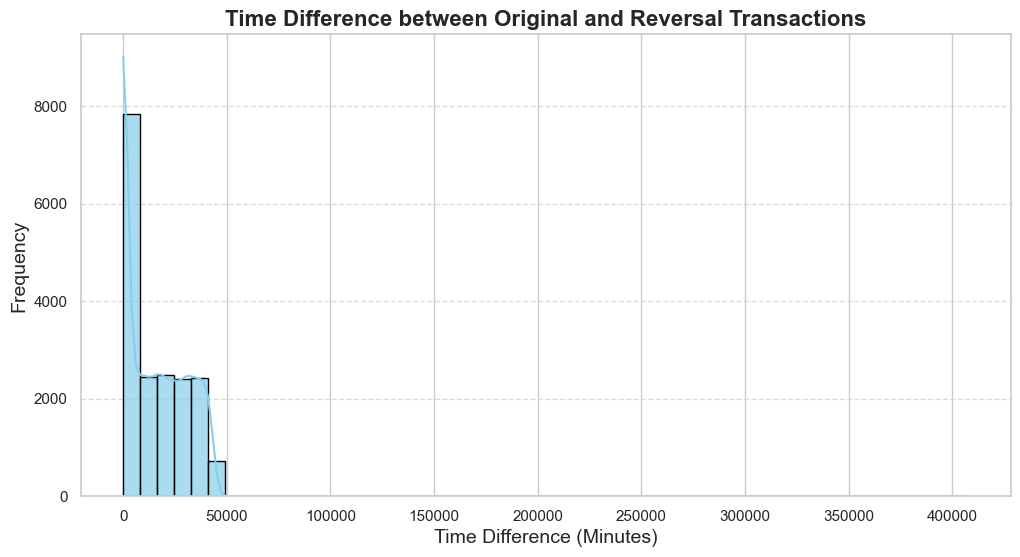

In [109]:
# Plotting the time difference between original and reversal transactions
plt.figure(figsize=(12, 6))
sns.histplot(matched_reversals_df['time_diff_minutes'], bins=50, kde=True, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Time Difference between Original and Reversal Transactions", fontsize=16, fontweight='bold')
plt.xlabel("Time Difference (Minutes)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [112]:
# 2. Identify multi-swipe transactions
# These are duplicate transactions with the same account, merchant, amount in a short time
multi_swipe_groups = []
multi_swipe_transactions = []
time_threshold = timedelta(minutes=5)  # 5 minute threshold

# Group by account, merchant, and amount
for account in df_dup['accountNumber'].unique():
    account_data = df_dup[df_dup['accountNumber'] == account]
    
    # Group by merchant and amount
    for merchant in account_data['merchantName'].unique():
        merchant_data = account_data[account_data['merchantName'] == merchant]
        
        for amount in merchant_data['transactionAmount'].unique():
            # Don't consider $0 transactions
            if amount == 0:
                continue
                
            # Get transactions with this exact amount
            amount_txns = merchant_data[
                (abs(merchant_data['transactionAmount'] - amount) < 0.01) &
                (merchant_data['transactionType'] != 'REVERSAL')
            ].sort_values('transactionDateTime')
            
            if len(amount_txns) > 1:
                # Check if any transactions are within the time threshold
                groups = []
                current_group = [amount_txns.iloc[0]]
                
                for i in range(1, len(amount_txns)):
                    prev_txn = amount_txns.iloc[i-1]
                    curr_txn = amount_txns.iloc[i]
                    
                    time_diff = curr_txn['transactionDateTime'] - prev_txn['transactionDateTime']
                    
                    if time_diff <= time_threshold:
                        # Add to current group
                        current_group.append(curr_txn)
                    else:
                        # Start a new group if the current group has multiple transactions
                        if len(current_group) > 1:
                            groups.append(current_group)
                        current_group = [curr_txn]
                
                # Add the last group if it has multiple transactions
                if len(current_group) > 1:
                    groups.append(current_group)
                
                # Add to multi-swipe groups
                for group in groups:
                    group_info = {
                        'accountNumber': account,
                        'merchantName': merchant,
                        'amount': amount,
                        'count': len(group),
                        'first_datetime': group[0]['transactionDateTime'],
                        'last_datetime': group[-1]['transactionDateTime'],
                        'time_span_seconds': (group[-1]['transactionDateTime'] - 
                                            group[0]['transactionDateTime']).total_seconds(),
                        'transaction_ids': [txn.name for txn in group]
                    }
                    multi_swipe_groups.append(group_info)
                    
                    # Add transactions to the list (excluding the first one)
                    for txn in group[1:]:
                        multi_swipe_transactions.append({
                            'group_id': len(multi_swipe_groups) - 1,
                            'transaction_id': txn.name,
                            'accountNumber': account,
                            'merchantName': merchant,
                            'amount': amount,
                            'datetime': txn['transactionDateTime']
                        })

# Create DataFrames
multi_swipe_groups_df = pd.DataFrame(multi_swipe_groups) if multi_swipe_groups else pd.DataFrame()
multi_swipe_transactions_df = pd.DataFrame(multi_swipe_transactions) if multi_swipe_transactions else pd.DataFrame()

# Calculate totals
total_multi_swipe_count = len(multi_swipe_transactions)
total_multi_swipe_amount = multi_swipe_transactions_df['amount'].sum() if len(multi_swipe_transactions) > 0 else 0

# Print summary statistics
print("\nReversal Transaction Analysis:")
print(f"- Total identified reversals: {len(matched_reversals)}")
print(f"- Total dollar amount of reversals: ${total_reversal_amount:.2f}")

if len(matched_reversals) > 0:
    print("\nSample reversal transactions:")
    # display(matched_reversals_df.head())
    print(matched_reversals_df.head())
    
    print("\nTime between original transaction and reversal:")
    print(f"- Mean: {matched_reversals_df['time_diff_minutes'].mean():.2f} minutes")
    print(f"- Median: {matched_reversals_df['time_diff_minutes'].median():.2f} minutes")
    print(f"- Min: {matched_reversals_df['time_diff_minutes'].min():.2f} minutes")
    print(f"- Max: {matched_reversals_df['time_diff_minutes'].max():.2f} minutes")

print("\nMulti-Swipe Transaction Analysis:")
print(f"- Total multi-swipe groups identified: {len(multi_swipe_groups)}")
print(f"- Total extra transactions (excluding first legitimate swipe): {total_multi_swipe_count}")
print(f"- Total dollar amount of extra swipes: ${total_multi_swipe_amount:.2f}")

if len(multi_swipe_groups) > 0:
    print("\nMulti-swipe group statistics:")
    print(f"- Average transactions per group: {multi_swipe_groups_df['count'].mean():.2f}")
    print(f"- Average time span: {multi_swipe_groups_df['time_span_seconds'].mean():.2f} seconds")
    
    print("\nSample multi-swipe groups:")
    if len(multi_swipe_groups_df) > 0:
        # display(multi_swipe_groups_df.head())
        print(multi_swipe_groups_df.head())


Reversal Transaction Analysis:
- Total identified reversals: 18356
- Total dollar amount of reversals: $2669647.74

Sample reversal transactions:
   reversal_id  original_id  accountNumber  amount         merchantName  \
0       541964       541963      100088067   22.32           AMC #79863   
1        87920        87919      100328049   43.74                 Lyft   
2        87936        87935      100328049  284.97    McDonalds #423357   
3       151499       151496      100737756   93.67     34th BBQ #436606   
4       151541       151534      100737756  501.29  Best Bistro #262998   

    original_datetime   reversal_datetime  time_diff_minutes  
0 2016-11-20 07:57:05 2016-11-20 08:00:04           2.983333  
1 2016-01-15 20:34:35 2016-01-15 20:36:18           1.716667  
2 2016-03-24 22:57:15 2016-03-26 17:35:09        2557.900000  
3 2016-05-30 00:42:32 2016-06-06 22:56:52       11414.333333  
4 2016-08-11 09:20:41 2016-08-24 20:21:19       19380.633333  

Time between original t

,accountNumber,merchantName,amount,count,first_datetime,last_datetime,time_span_seconds,transaction_ids
0,100088067,Fresh Flowers,411.35,2,2016-10-16 18:01:00,2016-10-16 18:01:02,2.0,"[541955, 541956]"
1,100737756,Franks Deli,693.50,3,2016-01-18 01:55:24,2016-01-18 01:58:26,182.0,"[151426, 151427, 151428]"
2,100737756,34th BBQ #166379,43.25,2,2016-07-10 14:31:07,2016-07-10 14:32:06,59.0,"[151517, 151518]"
3,100737756,South Steakhouse #73819,211.22,2,2016-07-02 12:05:04,2016-07-02 12:07:00,116.0,"[151512, 151513]"
4,101132326,Regal Cinemas #05791,188.86,2,2016-08-24 02:09:08,2016-08-24 02:09:44,36.0,"[220071, 220072]"


In [113]:
pd.to_pickle(multi_swipe_groups_df, 'multi_swipe_groups', protocol=4)

In [115]:
# 3. Identify recurring transactions
# These are regular transactions with the same amount and merchant
print("\nIdentifying recurring transactions...")
recurring_groups = []

# Group by account, merchant, and amount
for account in df_dup['accountNumber'].unique():
    account_data = df_dup[df_dup['accountNumber'] == account]
    
    # Group by merchant and amount
    for merchant in account_data['merchantName'].unique():
        merchant_data = account_data[account_data['merchantName'] == merchant]
        
        for amount in merchant_data['transactionAmount'].unique():
            # Don't consider $0 transactions
            if amount == 0:
                continue
                
            # Get transactions with this exact amount
            amount_txns = merchant_data[
                (abs(merchant_data['transactionAmount'] - amount) < 0.01) &
                (merchant_data['transactionType'] != 'REVERSAL')
            ].sort_values('transactionDateTime')
            
            # If we have more than 2 transactions with the same amount
            if len(amount_txns) > 2:
                # Calculate time differences between consecutive transactions
                time_diffs = []
                for i in range(1, len(amount_txns)):
                    time_diff = (amount_txns.iloc[i]['transactionDateTime'] - 
                                amount_txns.iloc[i-1]['transactionDateTime']).total_seconds() / (24 * 3600)  # in days
                    time_diffs.append(time_diff)
                
                # If average time diff is between 7 and 45 days, consider it recurring
                avg_time_diff = np.mean(time_diffs)
                if 7 <= avg_time_diff <= 45 and np.std(time_diffs) < avg_time_diff/2:
                    recurring_groups.append({
                        'accountNumber': account,
                        'merchantName': merchant,
                        'amount': amount,
                        'count': len(amount_txns),
                        'first_date': amount_txns.iloc[0]['transactionDateTime'],
                        'last_date': amount_txns.iloc[-1]['transactionDateTime'],
                        'avg_days_between': avg_time_diff,
                        'std_days_between': np.std(time_diffs),
                        'frequency': 'weekly' if avg_time_diff < 10 else 'bi-weekly' if avg_time_diff < 20 else 'monthly'
                    })

recurring_df = pd.DataFrame(recurring_groups) if recurring_groups else pd.DataFrame()

if len(recurring_df) > 0:
    print(f"\nIdentified {len(recurring_df)} potential recurring transaction patterns")
    print("\nSample recurring transaction patterns:")
    # display(recurring_df.head())
    print(recurring_df.head())
else:
    print("No recurring transaction patterns identified")


Identifying recurring transactions...

Identified 4378 potential recurring transaction patterns

Sample recurring transaction patterns:
   accountNumber       merchantName  amount  count          first_date  \
0      100088067       Apple iTunes    3.96      8 2016-05-05 22:47:50   
1      100088067  Shell Gas #256420   60.41      5 2016-10-10 05:55:58   
2      100108752  Shell Gas #494785   45.35     10 2016-05-07 21:37:09   
3      100328049         Play Store    3.33      6 2016-07-02 18:39:38   
4      100328049  Mobil Gas #841292   22.70      7 2016-09-01 02:15:13   

            last_date  avg_days_between  std_days_between  frequency  
0 2016-12-07 07:48:20         30.767907          0.611412    monthly  
1 2016-12-20 03:47:56         17.727772          6.373333  bi-weekly  
2 2016-12-03 01:49:18         23.241678          8.873337    monthly  
3 2016-12-03 22:06:16         30.828699          0.449599    monthly  
4 2016-12-22 17:37:00         18.773355          6.346881  bi-w

In [117]:
pd.to_pickle(recurring_df, 'recurring_transactions', protocol=4)

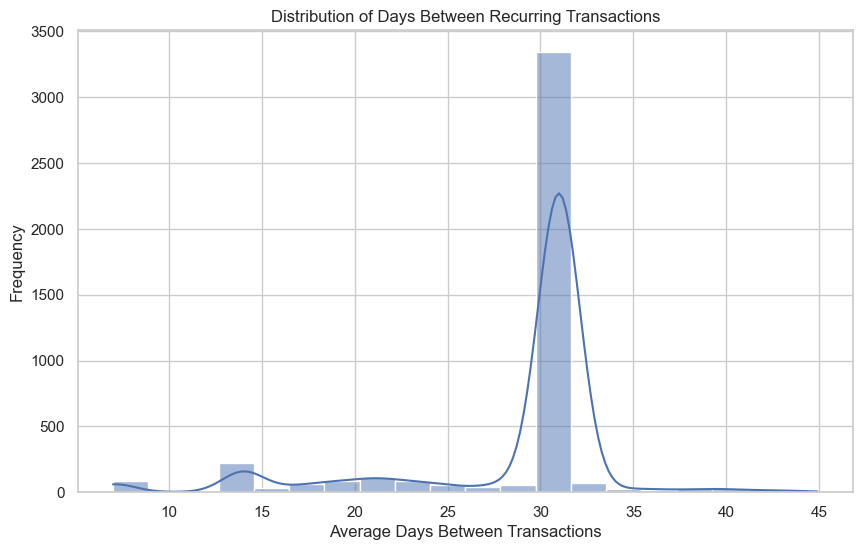

In [116]:
# Visualize the distribution of time between repeated transactions
if len(recurring_df) > 0:
    plt.figure(figsize=(10, 6))
    sns.histplot(recurring_df['avg_days_between'], bins=20, kde=True)
    plt.title('Distribution of Days Between Recurring Transactions')
    plt.xlabel('Average Days Between Transactions')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

GRID search, TRandomized Search, and so on can be helpful for choosing hyperparameters